<a href="https://colab.research.google.com/github/AARONGRANICH/MCD_ICDYM/blob/main/Coffee_con_modelos_pre_entrenados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
import numpy as np
import shutil

In [5]:
# Instalamos Kaggle para poder descargar las imágenes
!pip install -q kaggle
from google.colab import files

files.upload()
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d gpiosenka/coffee-bean-dataset-resized-224-x-224

Saving kaggle.json to kaggle.json
coffee-bean-dataset-resized-224-x-224.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
# Descomprimir y extraer información
!mkdir '/content/coffee-bean-dataset-resized-224-x-224'
!unzip /content/coffee-bean-dataset-resized-224-x-224.zip -d '/content/coffee-bean-dataset-resized-224-x-224/'

mkdir: cannot create directory ‘/content/coffee-bean-dataset-resized-224-x-224’: File exists
Archive:  /content/coffee-bean-dataset-resized-224-x-224.zip
replace /content/coffee-bean-dataset-resized-224-x-224/Coffee Bean.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
# Definimos los directorios de entrenamiento y prueba
train_dir = '/content/coffee-bean-dataset-resized-224-x-224/train'
test_dir = '/content/coffee-bean-dataset-resized-224-x-224/test'

In [8]:
# Generador de datos para preprocesamiento y estandarizar
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Cargar y preprocesar datos de entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Cargar y preprocesar datos de prueba
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

class_names = train_generator.class_indices
print(class_names)

for image_batch, labels_batch in train_generator:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

Found 1200 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
{'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}
(32, 224, 224, 3)
(32, 4)


In [9]:
# Cargar modelos preentrenados
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobilenet_v2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [10]:
# Definir el número de clases
num_classes = 4

In [11]:
# Congelar capas preentrenadas
for layer in vgg16_model.layers:
    layer.trainable = False

In [12]:
# Añadir capas personalizadas
custom_model = Sequential([
    vgg16_model,
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(units=num_classes, activation='softmax')
])

custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [13]:
# Entrenar el modelo
history = custom_model.fit(train_generator, epochs=15, validation_data=test_generator)

Epoch 1/15
38/38 [==============================] - 1028s 27s/step - loss: 2.0176 - accuracy: 0.3533 - val_loss: 1.3838 - val_accuracy: 0.7175
Epoch 2/15
38/38 [==============================] - 1021s 27s/step - loss: 1.3710 - accuracy: 0.4233 - val_loss: 1.1111 - val_accuracy: 0.8300
Epoch 3/15
38/38 [==============================] - 1017s 27s/step - loss: 1.2087 - accuracy: 0.4675 - val_loss: 0.8938 - val_accuracy: 0.8550
Epoch 4/15
38/38 [==============================] - 1018s 27s/step - loss: 1.1418 - accuracy: 0.4942 - val_loss: 0.8454 - val_accuracy: 0.8675
Epoch 5/15
38/38 [==============================] - 1017s 27s/step - loss: 1.0715 - accuracy: 0.5200 - val_loss: 0.7983 - val_accuracy: 0.8700
Epoch 6/15
38/38 [==============================] - 1003s 27s/step - loss: 1.0720 - accuracy: 0.4942 - val_loss: 0.7945 - val_accuracy: 0.9275
Epoch 7/15
38/38 [==============================] - 1018s 27s/step - loss: 1.0366 - accuracy: 0.5167 - val_loss: 0.7432 - val_accuracy: 0.8900

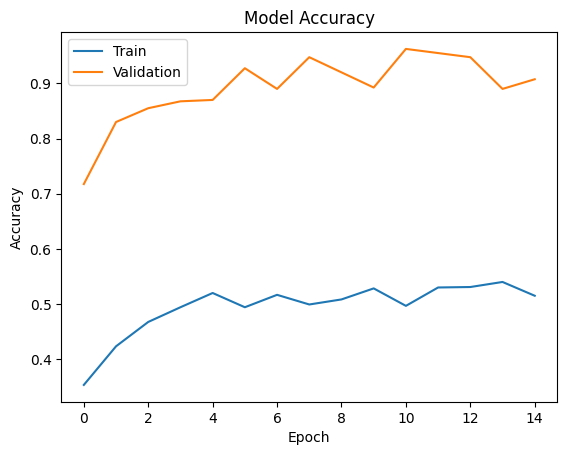

In [14]:
# Visualización de curvas de entrenamiento y validación
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [15]:
# Evaluar el modelo
loss, accuracy = custom_model.evaluate(test_generator)
print(f'Loss: {loss}, Accuracy: {accuracy}')

13/13 [==============================] - 248s 19s/step - loss: 0.5635 - accuracy: 0.9075
Loss: 0.5634865760803223, Accuracy: 0.9075000286102295


In [16]:
# Guardar el modelo
custom_model.save('custom_vgg16_Coffee_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Predicciones para la imagen de URL: https://media.istockphoto.com/id/693345668/es/foto/grano-de-caf%C3%A9-aislado-sobre-fondo-blanco.jpg?s=612x612&w=0&k=20&c=RVd5HsWp63sIEbGv6kdDEbriHoILBKGfJIjTFnPHCOg=
1/1 [==============================] - 1s 589ms/step


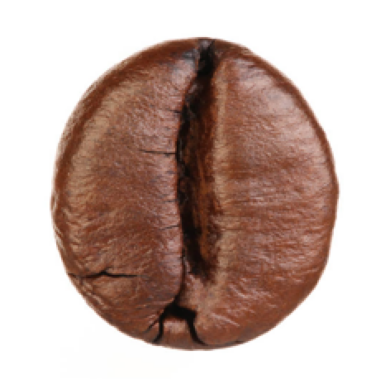

Predicciones para VGG16:

Top 1 predicciones:
Medium: 0.9864
Light: 0.0136
Dark: 0.0000


In [32]:
# Convertir el diccionario de class_indices a un diccionario simple
class_labels_simple = {class_idx: class_name for class_name, class_idx in train_generator.class_indices.items()}

# Definir la función de decodificación personalizada
def decode_predictions_custom(predictions, top=3, class_labels=None):
    if class_labels is None:
        raise ValueError("Debe proporcionar las etiquetas de las clases.")

    results = []
    for pred in predictions:
        top_indices = np.argsort(pred)[::-1][:top]
        result = [(class_labels[i], pred[i]) for i in top_indices]
        results.append(result)

    return results

# Corregir la función display_image_and_predictions_url para usar la nueva función de decodificación
def display_image_and_predictions_url(url, model, model_name, class_labels):
    # Cargar y preprocesar la imagen desde la URL
    img_array, img = load_and_preprocess_image_url(url)
    if img_array is None:
        return

    # Realizar la predicción
    predictions = model.predict(img_array)

    # Mostrar la imagen y las predicciones
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Decodificar y mostrar las predicciones
    decoded_predictions = decode_predictions_custom(predictions, top=3, class_labels=class_labels)
    print(f"Predicciones para {model_name}:")
    for i, result in enumerate(decoded_predictions):
        print(f"\nTop {i+1} predicciones:")
        for label, score in result:
            print(f"{label}: {score:.4f}")

# URL de ejemplo de una imagen de café (puedes cambiarla)
coffee_image_url = 'https://media.istockphoto.com/id/693345668/es/foto/grano-de-caf%C3%A9-aislado-sobre-fondo-blanco.jpg?s=612x612&w=0&k=20&c=RVd5HsWp63sIEbGv6kdDEbriHoILBKGfJIjTFnPHCOg='

# Iterar sobre los modelos y realizar predicciones con cada uno
for model, model_name in [(custom_model, 'VGG16')]:
    print(f"\nPredicciones para la imagen de URL: {coffee_image_url}")

    # Mostrar la imagen y las predicciones para cada modelo
    display_image_and_predictions_url(coffee_image_url, model, model_name, class_labels=class_labels_simple)


13/13 [==============================] - 266s 20s/step


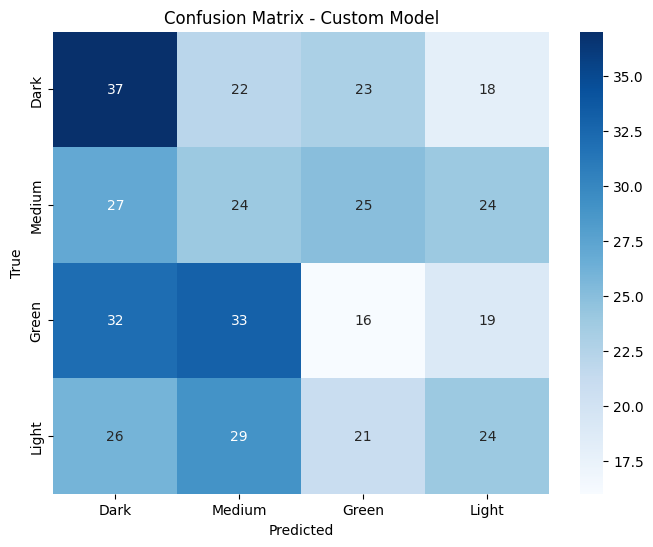

In [59]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtener las predicciones para el conjunto de prueba
y_true = test_generator.classes

# Obtener las predicciones del modelo personalizado
y_pred_custom = custom_model.predict(test_generator)

# Convertir las predicciones a etiquetas de clase
y_pred_custom_labels = np.argmax(y_pred_custom, axis=1)

# Calcular la matriz de confusión
cm_custom = confusion_matrix(y_true, y_pred_custom_labels)

# Función para visualizar la matriz de confusión
def plot_confusion_matrix(cm, class_names, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Etiquetas de clases
class_names = ['Dark', 'Medium', 'Green', 'Light',]

# Visualizar la matriz de confusión para el modelo personalizado
plot_confusion_matrix(cm_custom, class_names, 'Custom Model')

In [35]:
# Congelar capas preentrenadas
for layer in vgg19_model.layers:
    layer.trainable = False

In [36]:
# Añadir capas personalizadas
custom_model_vgg19 = Sequential([
    vgg19_model,
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(units=num_classes, activation='softmax')
])


In [37]:
# Compilar y Entrenar el Modelo
custom_model_vgg19.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
custom_model_vgg19.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
38/38 [==============================] - 1274s 34s/step - loss: 1.4290 - accuracy: 0.2867 - val_loss: 1.3863 - val_accuracy: 0.2525
Epoch 2/10
38/38 [==============================] - 1269s 34s/step - loss: 1.3862 - accuracy: 0.2600 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 3/10
38/38 [==============================] - 1263s 33s/step - loss: 1.3864 - accuracy: 0.2500 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 4/10
38/38 [==============================] - 1267s 34s/step - loss: 1.3864 - accuracy: 0.2500 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 5/10
38/38 [==============================] - 1271s 34s/step - loss: 1.3864 - accuracy: 0.2500 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 6/10
38/38 [==============================] - 1269s 34s/step - loss: 1.3864 - accuracy: 0.2500 - val_loss: 1.3863 - val_accuracy: 0.2500
Epoch 7/10
38/38 [==============================] - 1268s 34s/step - loss: 1.3865 - accuracy: 0.2500 - val_loss: 1.3863 - val_accuracy: 0.2500

In [38]:
# Evaluar el Modelo
loss, accuracy = custom_model_vgg19.evaluate(test_generator)
print(f'Loss: {loss}, Accuracy: {accuracy}')


13/13 [==============================] - 311s 24s/step - loss: 1.3863 - accuracy: 0.2500
Loss: 1.386296272277832, Accuracy: 0.25


In [39]:
# Guardar el Modelo Entrenado (Opcional)
custom_model_vgg19.save('/content/custom_vgg19_coffee_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Predicciones para la imagen de URL: https://media.istockphoto.com/id/693345668/es/foto/grano-de-caf%C3%A9-aislado-sobre-fondo-blanco.jpg?s=612x612&w=0&k=20&c=RVd5HsWp63sIEbGv6kdDEbriHoILBKGfJIjTFnPHCOg=
1/1 [==============================] - 2s 2s/step


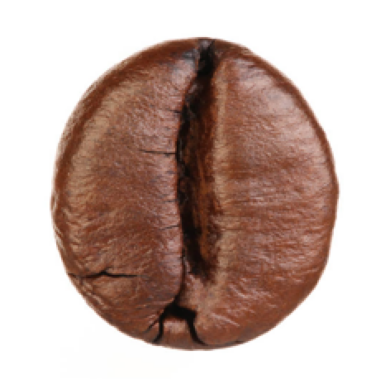

Predicciones para VGG19:

Top 1 predicciones:
Dark: 0.4723
Green: 0.2612
Medium: 0.1664


In [52]:
# Convertir el diccionario de class_indices a un diccionario simple
class_labels_simple = {class_idx: class_name for class_name, class_idx in train_generator.class_indices.items()}

# Definir la función de decodificación personalizada
def decode_predictions_custom(predictions, top=3, class_labels=None):
    if class_labels is None:
        raise ValueError("Debe proporcionar las etiquetas de las clases.")

    results = []
    for pred in predictions:
        top_indices = np.argsort(pred)[::-1][:top]
        result = [(class_labels[i], pred[i]) for i in top_indices]
        results.append(result)

    return results

# Corregir la función display_image_and_predictions_url para usar la nueva función de decodificación
def display_image_and_predictions_url(url, model, model_name, class_labels):
    # Cargar y preprocesar la imagen desde la URL
    img_array, img = load_and_preprocess_image_url(url)
    if img_array is None:
        return

    # Realizar la predicción
    predictions = model.predict(img_array)

    # Mostrar la imagen y las predicciones
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Decodificar y mostrar las predicciones
    decoded_predictions = decode_predictions_custom(predictions, top=3, class_labels=class_labels)
    print(f"Predicciones para {model_name}:")
    for i, result in enumerate(decoded_predictions):
        print(f"\nTop {i+1} predicciones:")
        for label, score in result:
            print(f"{label}: {score:.4f}")

# URL de ejemplo de una imagen de café (puedes cambiarla)
coffee_image_url = 'https://media.istockphoto.com/id/693345668/es/foto/grano-de-caf%C3%A9-aislado-sobre-fondo-blanco.jpg?s=612x612&w=0&k=20&c=RVd5HsWp63sIEbGv6kdDEbriHoILBKGfJIjTFnPHCOg='

# Iterar sobre los modelos y realizar predicciones con cada uno
for model, model_name in [(custom_model_vgg19, 'VGG19')]:
    print(f"\nPredicciones para la imagen de URL: {coffee_image_url}")

    # Mostrar la imagen y las predicciones para cada modelo
    display_image_and_predictions_url(coffee_image_url, model, model_name, class_labels=class_labels_simple)


13/13 [==============================] - 340s 26s/step


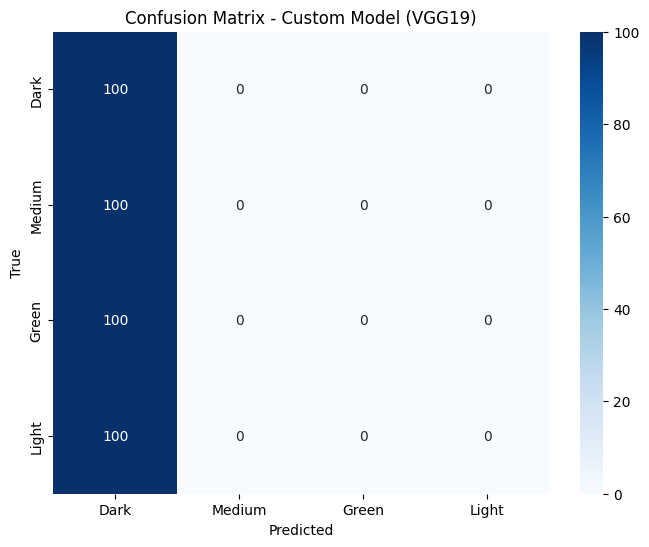

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtener las predicciones para el conjunto de prueba
y_true = test_generator.classes

# Obtener las predicciones del modelo personalizado basado en VGG19
y_pred_vgg19 = custom_model_vgg19.predict(test_generator)

# Convertir las predicciones a etiquetas de clase
y_pred_vgg19_labels = np.argmax(y_pred_vgg19, axis=1)

# Calcular la matriz de confusión
cm_vgg19 = confusion_matrix(y_true, y_pred_vgg19_labels)

# Función para visualizar la matriz de confusión
def plot_confusion_matrix(cm, class_names, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Etiquetas de clases
class_names = ['Dark', 'Medium', 'Green', 'Light']

# Visualizar la matriz de confusión para el modelo personalizado basado en VGG19
plot_confusion_matrix(cm_vgg19, class_names, 'Custom Model (VGG19)')


In [40]:
# Congelar capas preentrenadas para ResNet50
for layer in resnet50_model.layers:
    layer.trainable = False

In [41]:
# Añadir capas personalizadas para ResNet50
custom_model_resnet50 = Sequential([
    resnet50_model,
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(units=num_classes, activation='softmax')
])

In [42]:
# Compilar y entrenar el modelo para ResNet50
custom_model_resnet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_resnet50 = custom_model_resnet50.fit(train_generator, epochs=15, validation_data=test_generator)

Epoch 1/15
38/38 [==============================] - 408s 9s/step - loss: 6.7878 - accuracy: 0.3742 - val_loss: 1.3121 - val_accuracy: 0.5875
Epoch 2/15
38/38 [==============================] - 358s 9s/step - loss: 1.2623 - accuracy: 0.5833 - val_loss: 1.0476 - val_accuracy: 0.6450
Epoch 3/15
38/38 [==============================] - 360s 9s/step - loss: 1.1521 - accuracy: 0.5400 - val_loss: 1.0054 - val_accuracy: 0.6250
Epoch 4/15
38/38 [==============================] - 358s 9s/step - loss: 1.1030 - accuracy: 0.5450 - val_loss: 0.9035 - val_accuracy: 0.7050
Epoch 5/15
38/38 [==============================] - 359s 9s/step - loss: 1.0618 - accuracy: 0.5583 - val_loss: 0.9123 - val_accuracy: 0.5550
Epoch 6/15
38/38 [==============================] - 360s 9s/step - loss: 1.0171 - accuracy: 0.5617 - val_loss: 0.8796 - val_accuracy: 0.6650
Epoch 7/15
38/38 [==============================] - 360s 9s/step - loss: 1.0210 - accuracy: 0.5392 - val_loss: 0.7923 - val_accuracy: 0.6575
Epoch 8/15
38

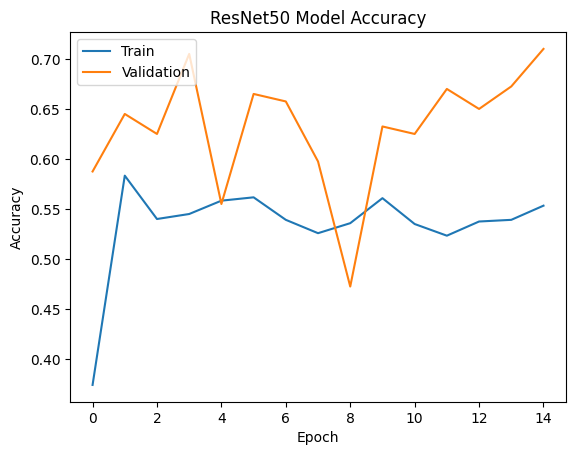

In [43]:
# Visualización de curvas de entrenamiento y validación para ResNet50
plt.plot(history_resnet50.history['accuracy'])
plt.plot(history_resnet50.history['val_accuracy'])
plt.title('ResNet50 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [44]:
# Evaluar el modelo para ResNet50
loss_resnet50, accuracy_resnet50 = custom_model_resnet50.evaluate(test_generator)
print(f'ResNet50 Model - Loss: {loss_resnet50}, Accuracy: {accuracy_resnet50}')

13/13 [==============================] - 81s 6s/step - loss: 0.6897 - accuracy: 0.7100
ResNet50 Model - Loss: 0.6897390484809875, Accuracy: 0.7099999785423279


In [45]:
# Guardar el modelo para ResNet50
custom_model_resnet50.save('custom_resnet50_Coffee_model.h5')


Predicciones para la imagen de URL: https://media.istockphoto.com/id/693345668/es/foto/grano-de-caf%C3%A9-aislado-sobre-fondo-blanco.jpg?s=612x612&w=0&k=20&c=RVd5HsWp63sIEbGv6kdDEbriHoILBKGfJIjTFnPHCOg=
1/1 [==============================] - 2s 2s/step


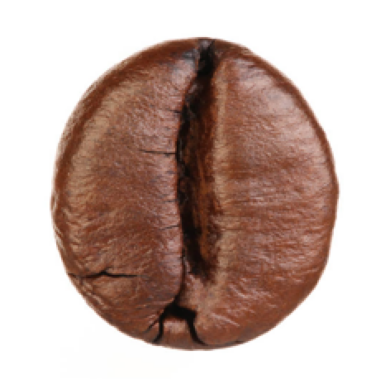

Predicciones para RESNET50:

Top 1 predicciones:
Dark: 0.5739
Medium: 0.4131
Light: 0.0129


In [53]:
# Convertir el diccionario de class_indices a un diccionario simple
class_labels_simple = {class_idx: class_name for class_name, class_idx in train_generator.class_indices.items()}

# Definir la función de decodificación personalizada
def decode_predictions_custom(predictions, top=3, class_labels=None):
    if class_labels is None:
        raise ValueError("Debe proporcionar las etiquetas de las clases.")

    results = []
    for pred in predictions:
        top_indices = np.argsort(pred)[::-1][:top]
        result = [(class_labels[i], pred[i]) for i in top_indices]
        results.append(result)

    return results

# Corregir la función display_image_and_predictions_url para usar la nueva función de decodificación
def display_image_and_predictions_url(url, model, model_name, class_labels):
    # Cargar y preprocesar la imagen desde la URL
    img_array, img = load_and_preprocess_image_url(url)
    if img_array is None:
        return

    # Realizar la predicción
    predictions = model.predict(img_array)

    # Mostrar la imagen y las predicciones
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Decodificar y mostrar las predicciones
    decoded_predictions = decode_predictions_custom(predictions, top=3, class_labels=class_labels)
    print(f"Predicciones para {model_name}:")
    for i, result in enumerate(decoded_predictions):
        print(f"\nTop {i+1} predicciones:")
        for label, score in result:
            print(f"{label}: {score:.4f}")

# URL de ejemplo de una imagen de café (puedes cambiarla)
coffee_image_url = 'https://media.istockphoto.com/id/693345668/es/foto/grano-de-caf%C3%A9-aislado-sobre-fondo-blanco.jpg?s=612x612&w=0&k=20&c=RVd5HsWp63sIEbGv6kdDEbriHoILBKGfJIjTFnPHCOg='

# Iterar sobre los modelos y realizar predicciones con cada uno
for model, model_name in [(custom_model_resnet50, 'RESNET50')]:
    print(f"\nPredicciones para la imagen de URL: {coffee_image_url}")

    # Mostrar la imagen y las predicciones para cada modelo
    display_image_and_predictions_url(coffee_image_url, model, model_name, class_labels=class_labels_simple)


13/13 [==============================] - 87s 7s/step


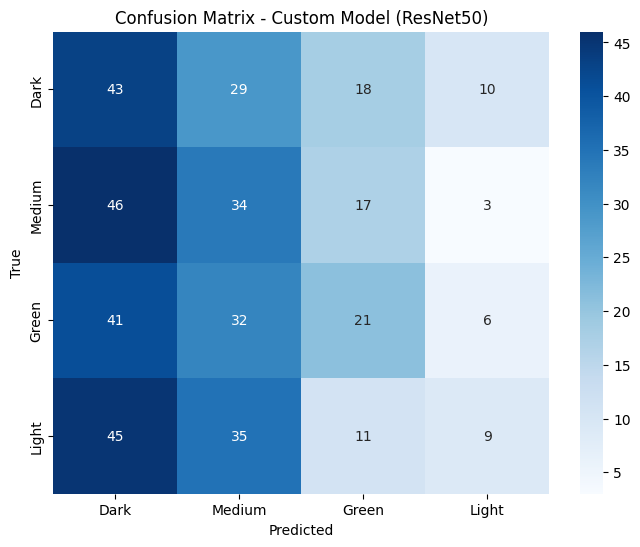

In [65]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtener las predicciones para el conjunto de prueba
y_true = test_generator.classes

# Obtener las predicciones del modelo personalizado basado en ResNet50
y_pred_resnet50 = custom_model_resnet50.predict(test_generator)

# Convertir las predicciones a etiquetas de clase
y_pred_resnet50_labels = np.argmax(y_pred_resnet50, axis=1)

# Calcular la matriz de confusión
cm_resnet50 = confusion_matrix(y_true, y_pred_resnet50_labels)

# Función para visualizar la matriz de confusión
def plot_confusion_matrix(cm, class_names, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Etiquetas de clases
class_names = ['Dark', 'Medium', 'Green', 'Light']

# Visualizar la matriz de confusión para el modelo personalizado basado en ResNet50
plot_confusion_matrix(cm_resnet50, class_names, 'Custom Model (ResNet50)')


In [46]:
# Congelar capas preentrenadas para MobileNetV2
for layer in mobilenet_v2_model.layers:
    layer.trainable = False

In [47]:
# Añadir capas personalizadas para MobileNetV2
custom_model_mobilenet_v2 = Sequential([
    mobilenet_v2_model,
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(units=num_classes, activation='softmax')
])

In [48]:
# Compilar y entrenar el modelo para MobileNetV2
custom_model_mobilenet_v2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_mobilenet_v2 = custom_model_mobilenet_v2.fit(train_generator, epochs=15, validation_data=test_generator)

Epoch 1/15
38/38 [==============================] - 114s 3s/step - loss: 8.4107 - accuracy: 0.7542 - val_loss: 3.0232 - val_accuracy: 0.9400
Epoch 2/15
38/38 [==============================] - 104s 3s/step - loss: 2.7886 - accuracy: 0.9033 - val_loss: 2.1124 - val_accuracy: 0.9700
Epoch 3/15
38/38 [==============================] - 97s 3s/step - loss: 2.0159 - accuracy: 0.9183 - val_loss: 1.6158 - val_accuracy: 0.9750
Epoch 4/15
38/38 [==============================] - 100s 3s/step - loss: 1.6168 - accuracy: 0.9217 - val_loss: 1.2435 - val_accuracy: 0.9975
Epoch 5/15
38/38 [==============================] - 94s 2s/step - loss: 1.4073 - accuracy: 0.9100 - val_loss: 1.0954 - val_accuracy: 0.9875
Epoch 6/15
38/38 [==============================] - 102s 3s/step - loss: 1.1827 - accuracy: 0.9183 - val_loss: 0.9213 - val_accuracy: 0.9875
Epoch 7/15
38/38 [==============================] - 100s 3s/step - loss: 1.0314 - accuracy: 0.9317 - val_loss: 0.7971 - val_accuracy: 0.9925
Epoch 8/15
38/3

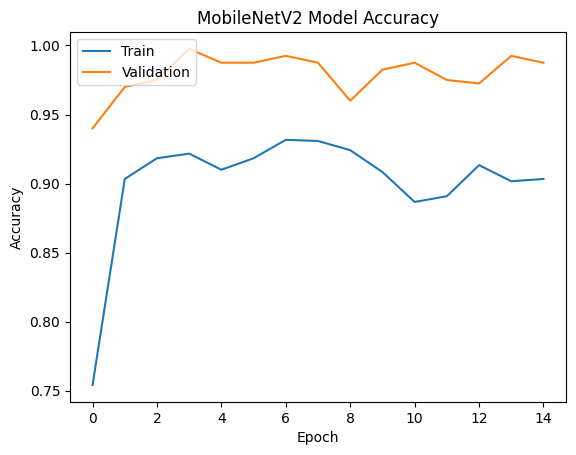

In [49]:
# Visualización de curvas de entrenamiento y validación para MobileNetV2
plt.plot(history_mobilenet_v2.history['accuracy'])
plt.plot(history_mobilenet_v2.history['val_accuracy'])
plt.title('MobileNetV2 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [50]:
# Evaluar el modelo para MobileNetV2
loss_mobilenet_v2, accuracy_mobilenet_v2 = custom_model_mobilenet_v2.evaluate(test_generator)
print(f'MobileNetV2 Model - Loss: {loss_mobilenet_v2}, Accuracy: {accuracy_mobilenet_v2}')

13/13 [==============================] - 17s 1s/step - loss: 0.4315 - accuracy: 0.9875
MobileNetV2 Model - Loss: 0.43148356676101685, Accuracy: 0.987500011920929


In [51]:
# Guardar el modelo para MobileNetV2
custom_model_mobilenet_v2.save('custom_mobilenet_v2_Coffee_model.h5')


Predicciones para la imagen de URL: https://media.istockphoto.com/id/693345668/es/foto/grano-de-caf%C3%A9-aislado-sobre-fondo-blanco.jpg?s=612x612&w=0&k=20&c=RVd5HsWp63sIEbGv6kdDEbriHoILBKGfJIjTFnPHCOg=
1/1 [==============================] - 0s 77ms/step


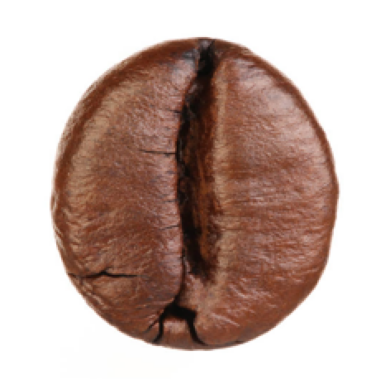

Predicciones para MOBILENETV2:

Top 1 predicciones:
Dark: 0.9980
Medium: 0.0020
Green: 0.0000


In [58]:
# Convertir el diccionario de class_indices a un diccionario simple
class_labels_simple = {class_idx: class_name for class_name, class_idx in train_generator.class_indices.items()}

# Definir la función de decodificación personalizada
def decode_predictions_custom(predictions, top=3, class_labels=None):
    if class_labels is None:
        raise ValueError("Debe proporcionar las etiquetas de las clases.")

    results = []
    for pred in predictions:
        top_indices = np.argsort(pred)[::-1][:top]
        result = [(class_labels[i], pred[i]) for i in top_indices]
        results.append(result)

    return results

# Corregir la función display_image_and_predictions_url para usar la nueva función de decodificación
def display_image_and_predictions_url(url, model, model_name, class_labels):
    # Cargar y preprocesar la imagen desde la URL
    img_array, img = load_and_preprocess_image_url(url)
    if img_array is None:
        return

    # Realizar la predicción
    predictions = model.predict(img_array)

    # Mostrar la imagen y las predicciones
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Decodificar y mostrar las predicciones
    decoded_predictions = decode_predictions_custom(predictions, top=3, class_labels=class_labels)
    print(f"Predicciones para {model_name}:")
    for i, result in enumerate(decoded_predictions):
        print(f"\nTop {i+1} predicciones:")
        for label, score in result:
            print(f"{label}: {score:.4f}")

# URL de ejemplo de una imagen de café (puedes cambiarla)
coffee_image_url = 'https://media.istockphoto.com/id/693345668/es/foto/grano-de-caf%C3%A9-aislado-sobre-fondo-blanco.jpg?s=612x612&w=0&k=20&c=RVd5HsWp63sIEbGv6kdDEbriHoILBKGfJIjTFnPHCOg='

# Iterar sobre los modelos y realizar predicciones con cada uno
for model, model_name in [(custom_model_mobilenet_v2, 'MOBILENETV2')]:
    print(f"\nPredicciones para la imagen de URL: {coffee_image_url}")

    # Mostrar la imagen y las predicciones para cada modelo
    display_image_and_predictions_url(coffee_image_url, model, model_name, class_labels=class_labels_simple)


13/13 [==============================] - 19s 1s/step


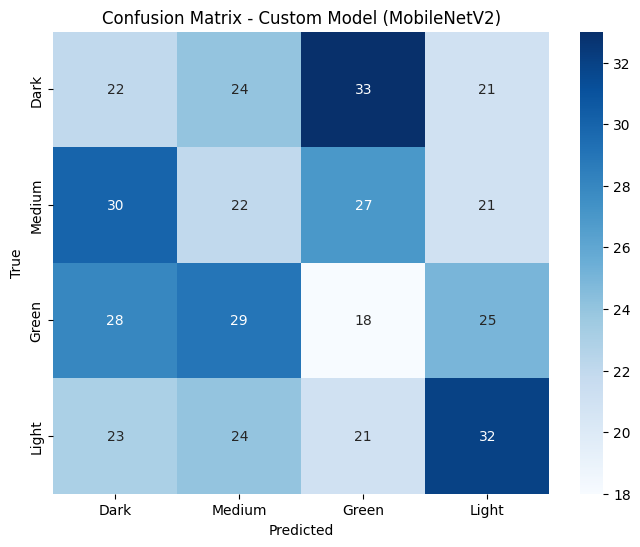

In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtener las predicciones para el conjunto de prueba
y_true = test_generator.classes

# Obtener las predicciones del modelo personalizado basado en MobileNetV2
y_pred_mobilenet_v2 = custom_model_mobilenet_v2.predict(test_generator)

# Convertir las predicciones a etiquetas de clase
y_pred_mobilenet_v2_labels = np.argmax(y_pred_mobilenet_v2, axis=1)

# Calcular la matriz de confusión
cm_mobilenet_v2 = confusion_matrix(y_true, y_pred_mobilenet_v2_labels)

# Función para visualizar la matriz de confusión
def plot_confusion_matrix(cm, class_names, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Etiquetas de clases
class_names = ['Dark', 'Medium', 'Green', 'Light']

# Visualizar la matriz de confusión para el modelo personalizado basado en MobileNetV2
plot_confusion_matrix(cm_mobilenet_v2, class_names, 'Custom Model (MobileNetV2)')
